In [30]:
from functions import *

import functions
from importlib import reload
reload(functions)

<module 'functions' from 'C:\\Users\\adam-\\Documents\\Thesis\\ThesisClustering\\functions.py'>

Short display of the data.

In [2]:
FULL_DF = pd.read_csv("philosophy_data.csv", converters={"tokenized_sentence": pd.eval})

In [3]:
#Filter dataframe to training, test, fulldataset
train_data = 0.8
indexes = [i for i in list(FULL_DF.sample(frac=train_data).index)]
DF_TRAIN = FULL_DF.iloc[indexes]
DF_TRAIN.reset_index(drop = True, inplace = True)
DF_TEST = FULL_DF.iloc[~FULL_DF.index.isin(indexes)]
DF_TEST.reset_index(drop = True, inplace = True)

#Comment these to be able to train.
DF_TEST = FULL_DF
DF_TRAIN = FULL_DF

len(FULL_DF.index), len(DF_TEST.index), len(DF_TRAIN.index)

(327431, 327431, 327431)

In [4]:
DF_TRAIN.sample(5)

,school,author,title,tokenized_sentence,num_of_chars,num_of_words,string_sentence
216762,aristotle,Aristotle,the complete works of aristotle vol 1,"[example, stand, long, liver, bileless, partic...",63,9,example stand long liver bileless particular l...
282749,german_idealism,Johann Gottlieb Fichte,the system of ethics,"[danger, threatened, deal, help, threatens]",37,5,danger threatened deal help threatens
3505,rationalism,Baruch Spinoza,ethics,[corollary],9,1,corollary
10175,rationalism,René Descartes,meditations on first philosophy,"[apologie, de, raimond, sebond]",26,4,apologie de raimond sebond
114117,phenomenology,Martin Heidegger,off the beaten track,"[stambaugh, new, york, harper, row]",29,5,stambaugh new york harper row


Extract the tokenized_sentence DF["tokenized_sentence"] sentences and append them into a python list.

Load w2v model, Skip-gram, CBOW

In [5]:
skipgram_w2v = Word2Vec(
            DF_TRAIN["tokenized_sentence"].tolist(),
            vector_size=300,       # Dimensionality of word embeddings
            sg = 1,                # SKIPGRAM
            window=5,              # Word window for context evaluation
            epochs=10)             # Number of epochs training over corpus

cbow_w2v = Word2Vec(
            DF_TRAIN["tokenized_sentence"].tolist(),
            vector_size=300,
            sg = 0,                # CBOW
            window=5,
            epochs=10)

len(skipgram_w2v.wv), len(cbow_w2v.wv)

(26754, 26754)

The sentence_vectorizer function summarizes each vectorized word in a sentence and divides the sum with the amount of words in the sentence.
Doing this will allow us to be able to get whole sentences vectorized values instead of individual words.
Using the function with our model (in this case w2v) sentences.
Can also be used with pretrained models.

In [6]:
DF_TEST, skipgram_sentences = vectorize_sentences(skipgram_w2v.wv, DF_TEST)
DF_TEST, cbow_sentences = vectorize_sentences(cbow_w2v.wv, DF_TEST)

#Should be equal
len(DF_TEST["tokenized_sentence"]), len(skipgram_sentences), len(cbow_sentences)

(326167, 326167, 326167)

Fetch the number of unique School of Thoughts.

In [7]:
unique_schools = DF_TEST["school"].unique().tolist()
print(unique_schools)
num_clusters = len(unique_schools)

['rationalism', 'analytic', 'empiricism', 'phenomenology', 'capitalism', 'continental', 'plato', 'aristotle', 'german_idealism', 'marxism']


Bar plot how many sentences are from each School of Thought.
(Show the total amount of real assigned SOT on each text.)

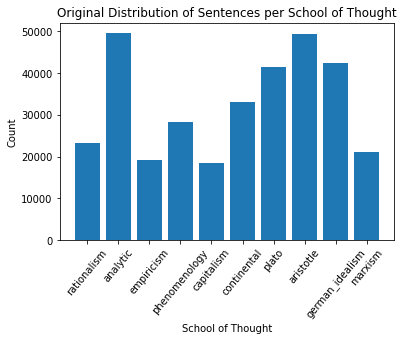

In [8]:
total_dict = dict.fromkeys(unique_schools, 0)
for school in DF_TEST["school"]:
    total_dict[school] += 1

plt.bar(range(len(total_dict)), total_dict.values(), align='center')
plt.xticks(range(len(total_dict)), total_dict.keys())
plt.xticks(rotation=50)
plt.xlabel("School of Thought")
plt.ylabel("Count")
plt.title("Original Distribution of Sentences per School of Thought")
plt.show()

Apply kmeans with num_clusters=amount of unique schools in the DF.

In [9]:
start = time.time()

#Skip-gram and cbow.
skipgram_w2v_kmeans, skipgram_w2v_labels, skipgram_w2v_centroids = apply_kmeans(num_clusters, skipgram_sentences)
cbow_w2v_kmeans, cbow_w2v_labels, cbow_w2v_centroids = apply_kmeans(num_clusters, cbow_sentences)

end = time.time()
print(end - start)

1167.2328369617462


Apply scatter plot on kmeans results using TSNE.
Scatter plot using TSNE, PCA and UMAP

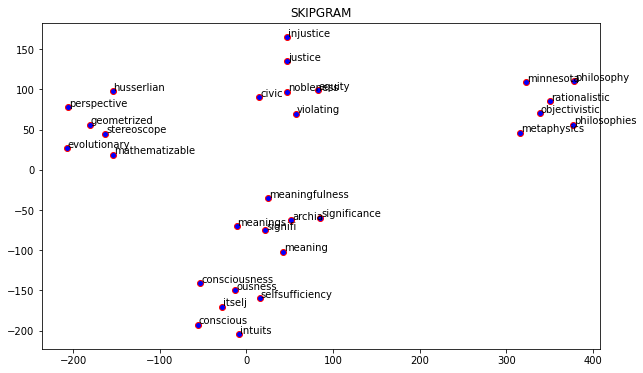

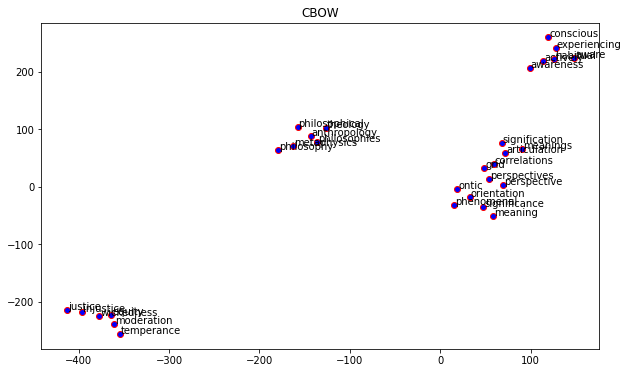

In [31]:
# scatter_plot(type='pca', labels=skipgram_w2v_labels, values=skipgram_sentences)
# scatter_plot(type='pca', labels=cbow_w2v_labels, values=cbow_sentences)

words = ['meaning', 'philosophy', 'justice', 'conscious', 'perspective']
plot_similar_words(skipgram_w2v.wv, words, title="SKIPGRAM",top_words=5)
plot_similar_words(cbow_w2v.wv, words,title="CBOW", top_words=5)

Combine the kmeans clustering results with the labels.
Put the kmeans result in a dictionary:

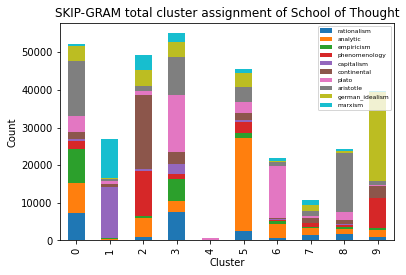

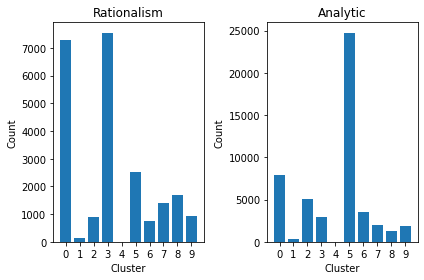

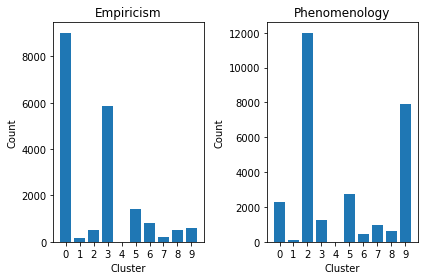

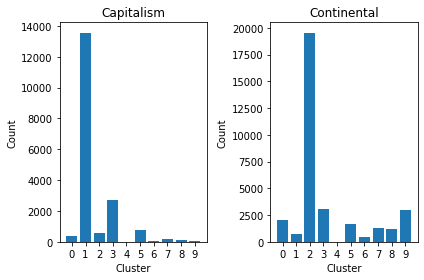

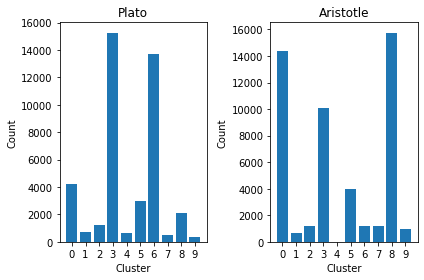

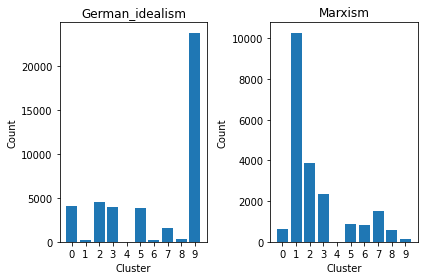

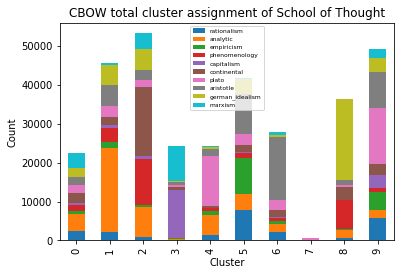

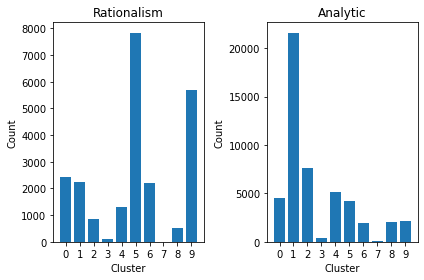

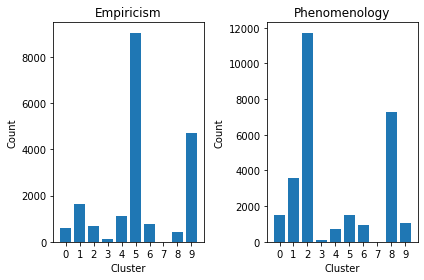

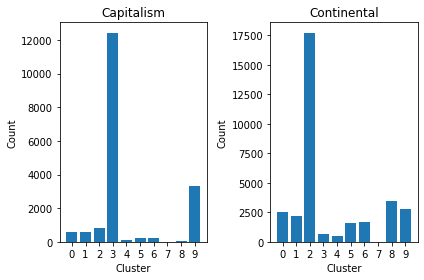

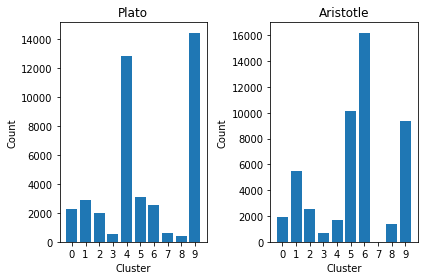

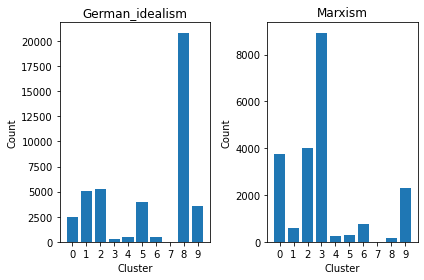

In [11]:
#How many times cluster n was assigned to specific SOT
cluster_n_assigned(DF=DF_TEST, labels=skipgram_w2v_labels, schools=unique_schools, name='skip-gram')
cluster_n_assigned(DF=DF_TEST, labels=cbow_w2v_labels, schools=unique_schools, name='cbow')

Make a list and convert all "plato" to 0 and "aristotle" to 1, etc.
This can then be applied with the predicted labels with v_measure.

In [12]:
original_labels = [unique_schools.index(school) for school in DF_TEST["school"]]

Apply v-measure.

In [13]:
#w2v
skipgram_v_measure = v_measure_score(original_labels, skipgram_w2v_labels)
cbow_v_measure = v_measure_score(original_labels, cbow_w2v_labels)

skipgram_v_measure, cbow_v_measure

(0.26481029791312916, 0.22907248966113838)

Calculate the best v_measure.
Apply different values for window/vector_size/iterations.
vector_size: 50 -> 100 -> 300
window: 2 -> 3 -> 5 -> 7

Saving the V-max in the dataframes.

In [14]:
#If want to train models on full corpus
train = False
#Iterations
epochs = 10
vector_size = 50
iterations = 10

v_measure_list_skipgram_2 = best_v_measure_w2v(FULL_DF=FULL_DF,train=train,train_ratio=0.8, window=2, epochs=epochs, iterations=iterations, vector_size=vector_size, model=1)
v_measure_list_cbow_2 = best_v_measure_w2v(FULL_DF=FULL_DF, train=train,train_ratio=0.8, window=2, epochs=epochs, iterations=iterations, vector_size=vector_size, model=0)

v_measure_list_skipgram_3 = best_v_measure_w2v(FULL_DF=FULL_DF,train=train,train_ratio=0.8, window=3, epochs=epochs,iterations=iterations, vector_size=vector_size, model=1)
v_measure_list_cbow_3 = best_v_measure_w2v(FULL_DF=FULL_DF, train=train,train_ratio=0.8, window=3, epochs=epochs, iterations=iterations, vector_size=vector_size, model=0)

v_measure_list_skipgram_5 = best_v_measure_w2v(FULL_DF=FULL_DF,train=train,train_ratio=0.8, window=5, epochs=epochs, iterations=iterations, vector_size=vector_size, model=1)
v_measure_list_cbow_5 = best_v_measure_w2v(FULL_DF=FULL_DF,train=train, train_ratio=0.8, window=5, epochs=epochs, iterations=iterations, vector_size=vector_size, model=0)

v_measure_list_skipgram_7 = best_v_measure_w2v(FULL_DF=FULL_DF,train=train,train_ratio=0.8, window=7, epochs=epochs,iterations=iterations, vector_size=vector_size, model=1)
v_measure_list_cbow_7 = best_v_measure_w2v(FULL_DF=FULL_DF, train=train,train_ratio=0.8, window=7, epochs=epochs, iterations=iterations, vector_size=vector_size, model=0)

Average Time per Iteration: 146.57970519065856
Average Time per Iteration: 137.6866830587387
Average Time per Iteration: 153.7191590309143
Average Time per Iteration: 117.05838279724121
Average Time per Iteration: 166.03968060016632
Average Time per Iteration: 143.07813925743102
Average Time per Iteration: 184.96392447948455
Average Time per Iteration: 129.26110413074494


In [15]:
v_measure_dict_50 = {"skipgram_2": v_measure_list_skipgram_2,
                        "skipgram_3": v_measure_list_skipgram_3,
                        "skipgram_5": v_measure_list_skipgram_5,
                        "skipgram_7": v_measure_list_skipgram_7,
                        "cbow_2": v_measure_list_cbow_2,
                        "cbow_3": v_measure_list_cbow_3,
                        "cbow_5": v_measure_list_cbow_5,
                        "cbow_7": v_measure_list_cbow_7}

# 50 Vec Size
v_measure_plot_dict_50 = {"Window_2": [max(v_measure_list_skipgram_2), max(v_measure_list_cbow_2)],
                           "Window_3": [max(v_measure_list_skipgram_3), max(v_measure_list_cbow_3)],
                           "Window_5": [max(v_measure_list_skipgram_5), max(v_measure_list_cbow_5)],
                           "Window_7": [max(v_measure_list_skipgram_7), max(v_measure_list_cbow_7)]}

df_v_measure_50 = pd.DataFrame.from_dict(v_measure_plot_dict_50, orient='index',
                       columns=["Skip-gram", "CBOW"])

df_v_measure_50.style.set_caption("Overview of V-measure results")

,Skip-gram,CBOW
Window_2,0.246877,0.217398
Window_3,0.254169,0.221566
Window_5,0.257896,0.223202
Window_7,0.263017,0.226974


In [16]:
#If want to train models on full corpus
train = False
#Iterations
epochs = 10
vector_size = 100
iterations = 10

v_measure_list_skipgram_2 = best_v_measure_w2v(FULL_DF=FULL_DF,train=train,train_ratio=0.8, window=2, epochs=epochs, iterations=iterations, vector_size=vector_size, model=1)
v_measure_list_cbow_2 = best_v_measure_w2v(FULL_DF=FULL_DF, train=train,train_ratio=0.8, window=2, epochs=epochs, iterations=iterations, vector_size=vector_size, model=0)

v_measure_list_skipgram_3 = best_v_measure_w2v(FULL_DF=FULL_DF,train=train,train_ratio=0.8, window=3, epochs=epochs,iterations=iterations, vector_size=vector_size, model=1)
v_measure_list_cbow_3 = best_v_measure_w2v(FULL_DF=FULL_DF, train=train,train_ratio=0.8, window=3, epochs=epochs, iterations=iterations, vector_size=vector_size, model=0)

v_measure_list_skipgram_5 = best_v_measure_w2v(FULL_DF=FULL_DF,train=train,train_ratio=0.8, window=5, epochs=epochs, iterations=iterations, vector_size=vector_size, model=1)
v_measure_list_cbow_5 = best_v_measure_w2v(FULL_DF=FULL_DF,train=train, train_ratio=0.8, window=5, epochs=epochs, iterations=iterations, vector_size=vector_size, model=0)

v_measure_list_skipgram_7 = best_v_measure_w2v(FULL_DF=FULL_DF,train=train,train_ratio=0.8, window=7, epochs=epochs,iterations=iterations, vector_size=vector_size, model=1)
v_measure_list_cbow_7 = best_v_measure_w2v(FULL_DF=FULL_DF, train=train,train_ratio=0.8, window=7, epochs=epochs, iterations=iterations, vector_size=vector_size, model=0)

Average Time per Iteration: 210.90443329811097
Average Time per Iteration: 181.62579057216644
Average Time per Iteration: 206.74344763755798
Average Time per Iteration: 197.83076729774476
Average Time per Iteration: 293.6318258047104
Average Time per Iteration: 223.81826748847962
Average Time per Iteration: 290.973281621933
Average Time per Iteration: 265.40604600906374


In [17]:
v_measure_dict_100 = {"skipgram_2": v_measure_list_skipgram_2,
                        "skipgram_3": v_measure_list_skipgram_3,
                        "skipgram_5": v_measure_list_skipgram_5,
                        "skipgram_7": v_measure_list_skipgram_7,
                        "cbow_2": v_measure_list_cbow_2,
                        "cbow_3": v_measure_list_cbow_3,
                        "cbow_5": v_measure_list_cbow_5,
                        "cbow_7": v_measure_list_cbow_7}

# 100 Vec Size
v_measure_plot_dict_100 = {"Window_2": [max(v_measure_list_skipgram_2), max(v_measure_list_cbow_2)],
                           "Window_3": [max(v_measure_list_skipgram_3), max(v_measure_list_cbow_3)],
                           "Window_5": [max(v_measure_list_skipgram_5), max(v_measure_list_cbow_5)],
                           "Window_7": [max(v_measure_list_skipgram_7), max(v_measure_list_cbow_7)]}

df_v_measure_100 = pd.DataFrame.from_dict(v_measure_plot_dict_100, orient='index',
                       columns=["Skip-gram", "CBOW"])

df_v_measure_100.style.set_caption("Overview of V-measure results")

,Skip-gram,CBOW
Window_2,0.251713,0.200366
Window_3,0.258896,0.223257
Window_5,0.262670,0.226995
Window_7,0.264440,0.229681


In [18]:
#If want to train models on full corpus
train = False
#Iterations
epochs = 10
vector_size = 300
iterations = 10

v_measure_list_skipgram_2 = best_v_measure_w2v(FULL_DF=FULL_DF,train=train,train_ratio=0.8, window=2, epochs=epochs, iterations=iterations, vector_size=vector_size, model=1)
v_measure_list_cbow_2 = best_v_measure_w2v(FULL_DF=FULL_DF, train=train,train_ratio=0.8, window=2, epochs=epochs, iterations=iterations, vector_size=vector_size, model=0)

v_measure_list_skipgram_3 = best_v_measure_w2v(FULL_DF=FULL_DF,train=train,train_ratio=0.8, window=3, epochs=epochs,iterations=iterations, vector_size=vector_size, model=1)
v_measure_list_cbow_3 = best_v_measure_w2v(FULL_DF=FULL_DF, train=train,train_ratio=0.8, window=3, epochs=epochs, iterations=iterations, vector_size=vector_size, model=0)

v_measure_list_skipgram_5 = best_v_measure_w2v(FULL_DF=FULL_DF,train=train,train_ratio=0.8, window=5, epochs=epochs, iterations=iterations, vector_size=vector_size, model=1)
v_measure_list_cbow_5 = best_v_measure_w2v(FULL_DF=FULL_DF,train=train, train_ratio=0.8, window=5, epochs=epochs, iterations=iterations, vector_size=vector_size, model=0)

v_measure_list_skipgram_7 = best_v_measure_w2v(FULL_DF=FULL_DF,train=train,train_ratio=0.8, window=7, epochs=epochs,iterations=iterations, vector_size=vector_size, model=1)
v_measure_list_cbow_7 = best_v_measure_w2v(FULL_DF=FULL_DF, train=train,train_ratio=0.8, window=7, epochs=epochs, iterations=iterations, vector_size=vector_size, model=0)

Average Time per Iteration: 630.8625959157944
Average Time per Iteration: 489.9315180301666
Average Time per Iteration: 518.3101577281952
Average Time per Iteration: 471.30935966968536
Average Time per Iteration: 548.7334992170333
Average Time per Iteration: 540.6628590583801
Average Time per Iteration: 625.9481965303421
Average Time per Iteration: 750.4308126688004


In [19]:
v_measure_dict_300 = {"skipgram_2": v_measure_list_skipgram_2,
                   "skipgram_3": v_measure_list_skipgram_3,
                   "skipgram_5": v_measure_list_skipgram_5,
                   "skipgram_7": v_measure_list_skipgram_7,
                   "cbow_2": v_measure_list_cbow_2,
                   "cbow_3": v_measure_list_cbow_3,
                   "cbow_5": v_measure_list_cbow_5,
                   "cbow_7": v_measure_list_cbow_7}

# 300 Vec Size
v_measure_plot_dict_300 = {"Window_2": [max(v_measure_list_skipgram_2), max(v_measure_list_cbow_2)],
                           "Window_3": [max(v_measure_list_skipgram_3), max(v_measure_list_cbow_3)],
                           "Window_5": [max(v_measure_list_skipgram_5), max(v_measure_list_cbow_5)],
                           "Window_7": [max(v_measure_list_skipgram_7), max(v_measure_list_cbow_7)]}

df_v_measure_300 = pd.DataFrame.from_dict(v_measure_plot_dict_300, orient='index',
                       columns=["Skip-gram", "CBOW"])

df_v_measure_300.style.set_caption("Overview of V-measure results")

,Skip-gram,CBOW
Window_2,0.256547,0.200967
Window_3,0.262497,0.203964
Window_5,0.265708,0.230018
Window_7,0.267738,0.232565
